📊 РІЧНІ ДАНІ (2014-2024):
               real_gdp  nominal_gdp  gov_spending  private_invest  \
2014-12-31  1566728.000     430217.8      430217.8        216927.4   
2015-12-31  1381338.451     576911.4      576911.4        251940.0   
2016-12-31  1479601.314     684743.4      684743.4        342059.4   
2017-12-31  1628803.297     839243.7      839243.7        429665.2   
2018-12-31  1769769.899     985842.0      985842.0        558496.3   
2019-12-31  1898731.077    1072891.5     1072891.5        626668.1   
2020-12-31  1908198.953    1288016.7     1288016.7        469493.1   
2021-12-31  2258139.339    1490258.9     1490258.9        585680.5   
2022-12-31  1695944.538    2705423.3     2705423.3        533484.2   
2023-12-31  2032304.831    4014418.1     4014418.1       1109627.6   
2024-12-31  2125642.714    4486682.7     4486682.7       -305255.5   

            interest_rate    cpi  budget_balance  
2014-12-31           14.0  124.9        -73133.6  
2015-12-31           22.0  143.

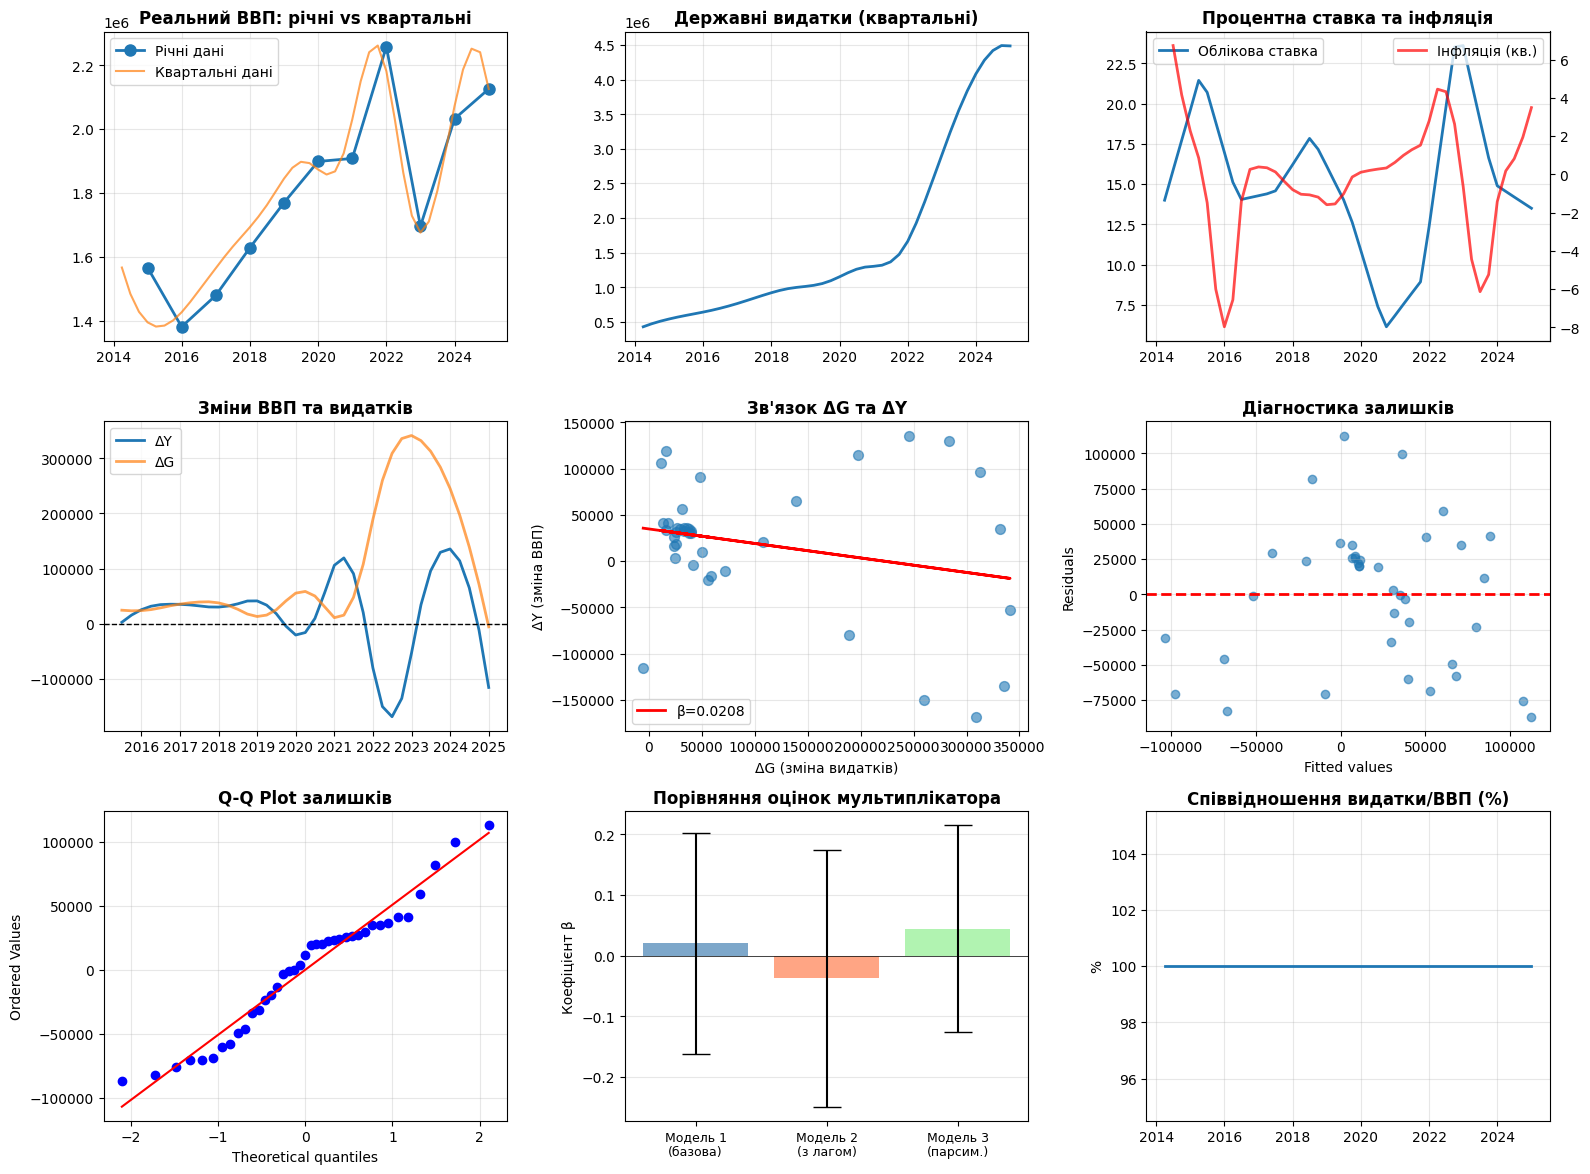

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS
from scipy import stats
from scipy.interpolate import CubicSpline, interp1d
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. ЗАВАНТАЖЕННЯ РІЧНИХ ДАНИХ
# ============================================================================

dates = pd.date_range('2014-01-01', '2024-12-31', freq='YE')
n = len(dates)

df_annual = pd.DataFrame({
    'real_gdp': [1566728,1381338.451,1479601.314,1628803.297,1769769.899,1898731.077,1908198.953,2258139.339,1695944.538,2032304.831,2125642.714],
    'nominal_gdp': [430217.8, 576911.4, 684743.4, 839243.7, 985842, 
                    1072891.5, 1288016.7, 1490258.9, 2705423.3, 
                    4014418.1, 4486682.7],
    'gov_spending': [430217.8, 576911.4, 684743.4, 839243.7, 985842, 
                     1072891.5, 1288016.7, 1490258.9, 2705423.3, 
                     4014418.1, 4486682.7],
    'private_invest': [216927.4, 251940, 342059.4, 429665.2, 558496.3, 
                       626668.1, 469493.1, 585680.5, 533484.2, 
                       1109627.6, -305255.5],
    'interest_rate': [14, 22, 14, 14.50, 18, 13.50, 6, 9, 25, 15, 13.50],
    'cpi': [124.9, 143.3, 112.4, 113.7, 109.8, 104.1, 105, 110, 126.6, 105.1, 112],
    'budget_balance': [-73133.6, -42216.6, -68600.5, -46011.2, -57800,\
-76777.2, -212094.3, -194309.9, -918038.5, -1342331.7, -1364823.2] 
}, index=dates)

print("📊 РІЧНІ ДАНІ (2014-2024):")
print(df_annual)
print(f"\n📅 Період: {df_annual.index[0].year} - {df_annual.index[-1].year}")
print(f"📈 Кількість років: {len(df_annual)}")

# ============================================================================
# 2. КОНВЕРТАЦІЯ У КВАРТАЛЬНІ ДАНІ
# ============================================================================

print("\n" + "="*80)
print("🔄 КОНВЕРТАЦІЯ У КВАРТАЛЬНІ ДАНІ")
print("="*80)

# Створюємо квартальний індекс
quarterly_dates = pd.date_range('2014-03-31', '2024-12-31', freq='QE')
df_quarterly = pd.DataFrame(index=quarterly_dates)

# Функція для інтерполяції різних типів змінних
def interpolate_to_quarterly(annual_series, method='cubic'):
    """
    Інтерполяція річних даних у квартальні
    
    Методи:
    - 'cubic': кубічний сплайн (для згладжених трендів)
    - 'linear': лінійна (для поступових змін)
    - 'pchip': монотонна (уникає осциляцій)
    """
    # Створюємо числовий індекс для річних даних
    x_annual = np.arange(len(annual_series))
    y_annual = annual_series.values
    
    # Числовий індекс для квартальних даних
    # 4 квартали = 1 рік, тому ділимо на 4
    x_quarterly = np.linspace(0, len(annual_series) - 1, len(quarterly_dates))
    
    if method == 'cubic':
        cs = CubicSpline(x_annual, y_annual)
        y_quarterly = cs(x_quarterly)
    elif method == 'linear':
        f = interp1d(x_annual, y_annual, kind='linear', fill_value='extrapolate')
        y_quarterly = f(x_quarterly)
    elif method == 'pchip':
        from scipy.interpolate import PchipInterpolator
        pchip = PchipInterpolator(x_annual, y_annual)
        y_quarterly = pchip(x_quarterly)
    
    return pd.Series(y_quarterly, index=quarterly_dates)

# Метод 1: Інтерполяція для потокових змінних (ВВП, витрати)
print("\n📌 Метод 1: Cubic Spline для ВВП та видатків")
df_quarterly['real_gdp'] = interpolate_to_quarterly(df_annual['real_gdp'], 'cubic')
df_quarterly['nominal_gdp'] = interpolate_to_quarterly(df_annual['nominal_gdp'], 'cubic')
df_quarterly['gov_spending'] = interpolate_to_quarterly(df_annual['gov_spending'], 'cubic')
df_quarterly['private_invest'] = interpolate_to_quarterly(df_annual['private_invest'], 'pchip')

# Метод 2: Лінійна інтерполяція для процентних ставок (більш стабільні)
print("📌 Метод 2: Лінійна інтерполяція для процентних ставок")
df_quarterly['interest_rate'] = interpolate_to_quarterly(df_annual['interest_rate'], 'linear')

# Метод 3: PCHIP (монотонна) для ІСЦ (уникає нереалістичних коливань)
print("📌 Метод 3: PCHIP для ІСЦ")
df_quarterly['cpi'] = interpolate_to_quarterly(df_annual['cpi'], 'pchip')

# Метод 4: Розподіл річного балансу на квартали
print("📌 Метод 4: Рівномірний розподіл бюджетного балансу")
# Для балансу краще розділити річне значення на 4 квартали
annual_balance_repeated = df_annual['budget_balance'].repeat(4)
df_quarterly['budget_balance'] = annual_balance_repeated.values[:len(quarterly_dates)] / 4

print(f"\n✅ Створено {len(df_quarterly)} квартальних спостережень")
print("\n📊 КВАРТАЛЬНІ ДАНІ (перші 8 кварталів):")
print(df_quarterly.head(8))

# ============================================================================
# 3. ДОДАВАННЯ КВАРТАЛЬНОЇ СЕЗОННОСТІ (опціонально)
# ============================================================================

print("\n" + "="*80)
print("🔄 ДОДАВАННЯ СЕЗОННИХ КОЕФІЦІЄНТІВ")
print("="*80)

# Типові сезонні коефіцієнти для України (можна налаштувати)
seasonal_factors = {
    'Q1': 1,  # Зима - зниження активності
    'Q2': 1,  # Весна - пожвавлення
    'Q3': 1,  # Літо - відпуски
    'Q4': 1   # Осінь - підвищена активність
}

# Додаємо сезонність до ВВП та інвестицій
df_quarterly['quarter'] = df_quarterly.index.quarter
df_quarterly['seasonal_factor'] = df_quarterly['quarter'].map({
    1: seasonal_factors['Q1'],
    2: seasonal_factors['Q2'],
    3: seasonal_factors['Q3'],
    4: seasonal_factors['Q4']
})

# Застосовуємо сезонність (опціонально)
df_quarterly['real_gdp_seasonal'] = df_quarterly['real_gdp'] * df_quarterly['seasonal_factor']
df_quarterly['private_invest_seasonal'] = df_quarterly['private_invest'] * df_quarterly['seasonal_factor']

# За замовчуванням використовуємо дані БЕЗ сезонності (можна змінити)
use_seasonal = False
if use_seasonal:
    df_quarterly['real_gdp'] = df_quarterly['real_gdp_seasonal']
    df_quarterly['private_invest'] = df_quarterly['private_invest_seasonal']
    print("✅ Застосовано сезонні коефіцієнти")
else:
    print("ℹ️  Сезонність не застосована (використовуються згладжені дані)")

# ============================================================================
# 4. РОЗРАХУНОК ЗМІННИХ ДЛЯ РЕГРЕСІЇ
# ============================================================================

print("\n" + "="*80)
print("📊 ПІДГОТОВКА ДАНИХ ДЛЯ РЕГРЕСІЇ")
print("="*80)

# Перша різниця
df_quarterly['delta_Y'] = df_quarterly['real_gdp'].diff()
df_quarterly['delta_G'] = df_quarterly['gov_spending'].diff()
df_quarterly['delta_I'] = df_quarterly['private_invest'].diff()

# Темпи зростання (квартал до кварталу)
df_quarterly['growth_Y'] = df_quarterly['real_gdp'].pct_change() * 100
df_quarterly['growth_G'] = df_quarterly['gov_spending'].pct_change() * 100

# Інфляція (квартальна)
df_quarterly['inflation_q'] = df_quarterly['cpi'].pct_change() * 100

# Лаги
df_quarterly['delta_G_lag1'] = df_quarterly['delta_G'].shift(1)
df_quarterly['delta_G_lag2'] = df_quarterly['delta_G'].shift(2)
df_quarterly['delta_G_lag3'] = df_quarterly['delta_G'].shift(3)
df_quarterly['delta_G_lag4'] = df_quarterly['delta_G'].shift(4)
df_quarterly['gov_spending_lag1'] = df_quarterly['gov_spending'].shift(1)
df_quarterly['real_gdp_lag1'] = df_quarterly['real_gdp'].shift(1)

# Співвідношення видатки/ВВП
df_quarterly['g_to_gdp'] = (df_quarterly['gov_spending'] / 
                            df_quarterly['nominal_gdp'] * 100)

# Видаляємо пропущені значення
df_reg = df_quarterly.dropna()

print(f"\n✅ Кількість спостережень для регресії: {len(df_reg)}")
print("\n📉 Статистика ключових змінних:")
print(df_reg[['delta_Y', 'delta_G', 'growth_Y', 'inflation_q']].describe())

# ============================================================================
# 5. БАЗОВА OLS РЕГРЕСІЯ З ROBUST SE
# ============================================================================

print("\n" + "="*80)
print("🔵 БАЗОВА РЕГРЕСІЯ: ΔY_t = α + β ΔG_t + γ X_t + ε_t")
print("="*80)

# Модель 1: Базова специфікація
y = df_reg['delta_Y']
X1 = df_reg[['delta_G', 'interest_rate', 'delta_I', 'inflation_q']]
X1 = sm.add_constant(X1)

model1 = OLS(y, X1).fit(cov_type='HC1')

print("\n📊 Модель 1 - Базова специфікація:")
print(model1.summary())

beta1 = model1.params['delta_G']
se1 = model1.bse['delta_G']

print(f"\n🎯 КЛЮЧОВІ РЕЗУЛЬТАТИ (Модель 1):")
print(f"   β = {beta1:.6f}")
print(f"   SE(β) = {se1:.6f}")
print(f"   t-stat = {model1.tvalues['delta_G']:.4f}")
print(f"   p-value = {model1.pvalues['delta_G']:.4f}")
print(f"   95% CI: [{beta1 - 1.96*se1:.6f}, {beta1 + 1.96*se1:.6f}]")

# Модель 2: З лагом ВВП (контроль за циклом)
X2 = df_reg[['delta_G', 'interest_rate', 'delta_I', 'inflation_q', 'real_gdp_lag1']]
X2 = sm.add_constant(X2)

model2 = OLS(y, X2).fit(cov_type='HC1')

print("\n📊 Модель 2 - З лагом ВВП:")
beta2 = model2.params['delta_G']
se2 = model2.bse['delta_G']
print(f"   β = {beta2:.6f} (SE = {se2:.6f})")
print(f"   p-value = {model2.pvalues['delta_G']:.4f}")

# Модель 3: Парсимонійна (лише ключові змінні)
X3 = df_reg[['delta_G', 'interest_rate', 'inflation_q']]
X3 = sm.add_constant(X3)

model3 = OLS(y, X3).fit(cov_type='HC1')

print("\n📊 Модель 3 - Парсимонійна:")
beta3 = model3.params['delta_G']
se3 = model3.bse['delta_G']
print(f"   β = {beta3:.6f} (SE = {se3:.6f})")
print(f"   p-value = {model3.pvalues['delta_G']:.4f}")

# ============================================================================
# 6. ТЕСТИ НА ЕНДОГЕННІСТЬ
# ============================================================================

print("\n" + "="*80)
print("🟠 ТЕСТИ НА ЕНДОГЕННІСТЬ")
print("="*80)

# DWH тест
print("\n📌 Тест Дурбіна-Ву-Гаусмана:")

instruments = ['delta_G_lag1', 'delta_G_lag2', 'interest_rate', 'inflation_q']
X_iv = df_reg[instruments]
X_iv = sm.add_constant(X_iv)

try:
    first_stage = OLS(df_reg['delta_G'], X_iv).fit()
    residuals_first = first_stage.resid
    
    X_aug = X1.copy()
    X_aug['first_stage_resid'] = residuals_first
    
    dwh_model = OLS(y, X_aug).fit()
    dwh_stat = dwh_model.tvalues['first_stage_resid']
    dwh_pvalue = dwh_model.pvalues['first_stage_resid']
    
    print(f"   t-статистика: {dwh_stat:.4f}")
    print(f"   p-value: {dwh_pvalue:.4f}")
    
    if dwh_pvalue < 0.05:
        print("   ⚠️  ВИСНОВОК: Є ознаки ендогенності (p < 0.05)")
    elif dwh_pvalue < 0.10:
        print("   ⚠️  ВИСНОВОК: Слабкі ознаки ендогенності (p < 0.10)")
    else:
        print("   ✅ ВИСНОВОК: Немає значущих ознак ендогенності")
except Exception as e:
    print(f"   ⚠️  Помилка при обчисленні: {str(e)}")
    dwh_pvalue = np.nan

# ============================================================================
# 7. ІНСТРУМЕНТАЛЬНІ ЗМІННІ (2SLS)
# ============================================================================

print("\n" + "="*80)
print("🟠 РЕГРЕСІЯ З ІНСТРУМЕНТАЛЬНИМИ ЗМІННИМИ (2SLS)")
print("="*80)

try:
    endog = df_reg['delta_Y']
    exog = df_reg[['interest_rate', 'delta_I', 'inflation_q']]
    exog = sm.add_constant(exog)
    
    endog_var = df_reg[['delta_G']]
    instruments = df_reg[['delta_G_lag1', 'delta_G_lag2', 'delta_G_lag3', 'gov_spending_lag1']]
    
    model_iv = IV2SLS(endog, exog, endog_var, instruments).fit()
    
    print("\n📊 Результати 2SLS:")
    print(model_iv.summary())
    
    beta_iv = model_iv.params['delta_G']
    se_iv = model_iv.bse['delta_G']
    
    print(f"\n🎯 КЛЮЧОВІ РЕЗУЛЬТАТИ (IV):")
    print(f"   β_IV = {beta_iv:.6f}")
    print(f"   SE(β_IV) = {se_iv:.6f}")
    print(f"   95% CI: [{beta_iv - 1.96*se_iv:.6f}, {beta_iv + 1.96*se_iv:.6f}]")
    
    # Перевірка інструментів
    print(f"\n📊 ВАЛІДНІСТЬ ІНСТРУМЕНТІВ:")
    print(f"   F-статистика першої стадії: {first_stage.fvalue:.4f}")
    if first_stage.fvalue > 10:
        print("   ✅ Інструменти сильні (F > 10)")
    elif first_stage.fvalue > 5:
        print("   ⚠️  Інструменти помірні (5 < F < 10)")
    else:
        print("   ⚠️  Інструменти слабкі (F < 5)")
    
    print(f"   R² першої стадії: {first_stage.rsquared:.4f}")
    
except Exception as e:
    print(f"⚠️  Помилка 2SLS: {str(e)}")
    print("   Можлива причина: слабкі інструменти або мала вибірка")
    beta_iv = np.nan
    se_iv = np.nan

# ============================================================================
# 8. ВІЗУАЛІЗАЦІЯ
# ============================================================================

print("\n📈 Створення графіків...")

fig = plt.figure(figsize=(16, 12))

# 1. Порівняння річних та квартальних даних
ax1 = plt.subplot(3, 3, 1)
ax1.plot(df_annual.index, df_annual['real_gdp'], 'o-', 
         label='Річні дані', markersize=8, linewidth=2)
ax1.plot(df_quarterly.index, df_quarterly['real_gdp'], '-', 
         label='Квартальні дані', alpha=0.7, linewidth=1.5)
ax1.set_title('Реальний ВВП: річні vs квартальні', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Державні видатки
ax2 = plt.subplot(3, 3, 2)
ax2.plot(df_quarterly.index, df_quarterly['gov_spending'], linewidth=2)
ax2.set_title('Державні видатки (квартальні)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Процентна ставка та інфляція
ax3 = plt.subplot(3, 3, 3)
ax3.plot(df_quarterly.index, df_quarterly['interest_rate'], 
         label='Облікова ставка', linewidth=2)
ax3_twin = ax3.twinx()
ax3_twin.plot(df_quarterly.index, df_quarterly['inflation_q'], 
              'r-', label='Інфляція (кв.)', linewidth=2, alpha=0.7)
ax3.set_title('Процентна ставка та інфляція', fontweight='bold')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# 4. Зміни ВВП та видатків
ax4 = plt.subplot(3, 3, 4)
ax4.plot(df_reg.index, df_reg['delta_Y'], label='ΔY', linewidth=2)
ax4.plot(df_reg.index, df_reg['delta_G'], label='ΔG', linewidth=2, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_title('Зміни ВВП та видатків', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Діаграма розсіювання
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(df_reg['delta_G'], df_reg['delta_Y'], alpha=0.6, s=50)
z = np.polyfit(df_reg['delta_G'], df_reg['delta_Y'], 1)
p = np.poly1d(z)
ax5.plot(df_reg['delta_G'], p(df_reg['delta_G']), 'r-', 
         linewidth=2, label=f'β={beta1:.4f}')
ax5.set_xlabel('ΔG (зміна видатків)')
ax5.set_ylabel('ΔY (зміна ВВП)')
ax5.set_title('Зв\'язок ΔG та ΔY', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Залишки
ax6 = plt.subplot(3, 3, 6)
ax6.scatter(model1.fittedvalues, model1.resid, alpha=0.6)
ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax6.set_xlabel('Fitted values')
ax6.set_ylabel('Residuals')
ax6.set_title('Діагностика залишків', fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Q-Q plot
ax7 = plt.subplot(3, 3, 7)
stats.probplot(model1.resid, dist="norm", plot=ax7)
ax7.set_title('Q-Q Plot залишків', fontweight='bold')
ax7.grid(True, alpha=0.3)

# 8. Порівняння моделей
ax8 = plt.subplot(3, 3, 8)
models = ['Модель 1\n(базова)', 'Модель 2\n(з лагом)', 'Модель 3\n(парсим.)']
betas = [beta1, beta2, beta3]
ses = [se1, se2, se3]

x_pos = np.arange(len(models))
ax8.bar(x_pos, betas, yerr=[1.96*s for s in ses], 
        alpha=0.7, capsize=10, color=['steelblue', 'coral', 'lightgreen'])
ax8.set_xticks(x_pos)
ax8.set_xticklabels(models, fontsize=9)
ax8.set_ylabel('Коефіцієнт β')
ax8.set_title('Порівняння оцінок мультиплікатора', fontweight='bold')
ax8.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax8.grid(True, alpha=0.3, axis='y')

# 9. Співвідношення видатки/ВВП
ax9 = plt.subplot(3, 3, 9)
ax9.plot(df_quarterly.index, df_quarterly['g_to_gdp'], linewidth=2)
ax9.set_title('Співвідношення видатки/ВВП (%)', fontweight='bold')
ax9.set_ylabel('%')
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fiscal_multiplier_quarterly.png', dpi=300, bbox_inches='tight')
print("✅ Графіки збережено: fiscal_multiplier_quarterly.png")

# ============================================================================
# 9. ПІДСУМКОВА ТАБЛИЦЯ
# ============================================================================

print("\n" + "="*80)
print("📋 ПІДСУМОК АНАЛІЗУ")
print("="*80)

summary_table = pd.DataFrame({
    'Модель': ['OLS (базова)', 'OLS (з лагом)', 'OLS (парсим.)', '2SLS (IV)'],
    'β': [beta1, beta2, beta3, beta_iv],
    'SE(β)': [se1, se2, se3, se_iv],
    't-stat': [model1.tvalues['delta_G'], model2.tvalues['delta_G'], 
               model3.tvalues['delta_G'], np.nan],
    'p-value': [model1.pvalues['delta_G'], model2.pvalues['delta_G'],
                model3.pvalues['delta_G'], np.nan],
    'R²': [model1.rsquared, model2.rsquared, model3.rsquared, np.nan],
    'N': [len(df_reg)] * 4
})

print("\n📊 Порівняння моделей:")
print(summary_table.to_string(index=False))

print(f"\n🎯 ОСНОВНІ ВИСНОВКИ:")
print(f"   1. Фіскальний мультиплікатор (базова модель): β = {beta1:.4f}")
print(f"   2. Статистична значущість: {'ТАК' if model1.pvalues['delta_G'] < 0.05 else 'НІ'} (p={model1.pvalues['delta_G']:.4f})")
print(f"   3. Ендогенність: {'ВИЯВЛЕНА' if dwh_pvalue < 0.05 else 'НЕ ВИЯВЛЕНА'}")
print(f"   4. Кількість спостережень: {len(df_reg)}")
print(f"   5. Період: {df_reg.index[0].strftime('%Y-Q%q')} - {df_reg.index[-1].strftime('%Y-Q%q')}")

print("\n" + "="*80)